# Qwen inference
This NB uses my finetuned qwen model to run inference on Jawi text.

In [1]:
#pip install -r requirements.txt

In [2]:
import torch

In [3]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

/usr/lib/python3/dist-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [4]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [5]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
import torch
from qwen_vl_utils import process_vision_info
from PIL import Image
from datasets import load_dataset
import pandas as pd

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-12 08:23:49.156914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741767829.184958    3914 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741767829.197913    3914 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
with open("tokens/token") as f:
    write_token = f.read()

with open("tokens/read_token") as f:
    read_token = f.read()

In [ ]:
model_name = 'mevsg/Qwen-Gongguan-OCR-v1'

# Load the fine-tuned model from Hugging Face Hub
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    token=read_token,
    torch_dtype=torch.bfloat16,  # Use the appropriate torch dtype if needed
    device_map='auto'            # Optional: automatically allocate model layers across devices
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:26<00:00, 13.28s/it]


In [7]:
model = model.half()

In [8]:
# Load the processor from Hugging Face Hub
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Run inference at scale
I will run inference on the validation dataset and save the results to a pandas DF. Then I can calculate the differences using my OCR metrics.

In [9]:
from copy import deepcopy

In [10]:
messages_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": None,  # Placeholder for image, to be updated
            },
            {"type": "text", "text": "Convert this image to text"},
        ],
    }
]

In [11]:
def process_image(image):
    messages = deepcopy(messages_template)
    messages[0]["content"][0]["image"] = image
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

In [12]:
# Load validation split only and select columns "text" and "im"
dataset = load_dataset('mevsg/Gongguan-OCR-v1', split='validation')

Generating validation split: 100%|██████████| 14/14 [00:00<00:00, 1673.08 examples/s]


In [13]:
results = []
counter = 1

for example in dataset:
    text = example['text']  # Ground truth
    image = example['image']   # Image data
    identifier = example['identifier']

    # Process the image
    prediction = process_image(image)

    # Save the result as a dictionary
    results.append({'ground_truth': text, 'prediction': prediction, 'identifier':identifier})
    #print(f"Processed image number {counter}", end="\r", flush=True)
    counter+=1

# Convert the results into a pandas DataFrame
df = pd.DataFrame(results)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 1

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 2

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 3

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 4

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 5

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 6

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 7

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 8

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 9

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 10

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 11

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 12

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 13

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 14

In [14]:
df.head()

,ground_truth,prediction,identifier
0,林黄當甲甲事 丁 十 一 月 十 一 日 和 1 7 8 7 年 ...,林黃當甲甲事 丁 十 一 月 十 一 日 和 1 7 8 7 年 ...,0009_p009_r_13
1,李溫阿端七壽叫,李溫阿端七壽,0009_p009_r_21
2,甲必丹大府中嘧喳嘮,甲必丹大府中嘧喳一勞,0010_p010_r_22
3,止仔得公其並之堂餘稱 會三亭 議個事 爲月例 雷該錢 珍錢全 蘭壹年 高百共 根柒七 官拾百...,"公止堂并仔稱其餘會議三稱為亭事, 例錢高該蘭珍全年俱根, 原七百官棄, 根拾五世之, 久文夫...",0009_p009_r_8
4,甲喳堂身坐林必嘮交則錢聽丹要黄可五供大討倦兹拾謂投使收聽文聽告費入復並前彼 懇臨幼有時外乞吧...,堂林坐黄魁辱交坐甲供五思辱论貳兒貰可要謂赚大堂乞使入積悲黄積存報告外懇着陸漸鈸着收辱鈸生寄 ...,0003_p003_r_9


In [18]:
df.to_csv('qwen_predictions.csv', index=False)

In [19]:
count_equal = (df['ground_truth'] == df['prediction']).sum()

In [20]:
count_equal/len(df)

0.0

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 0

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 1

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 2

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 3

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 4

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 5

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 6

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 7

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 8

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 9

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 10

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 11

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 12

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Processed image number 13
Total processed: 14


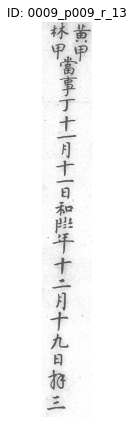

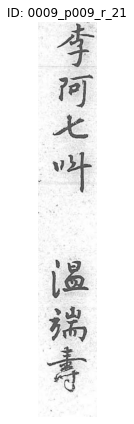

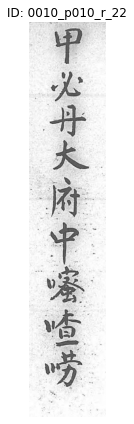

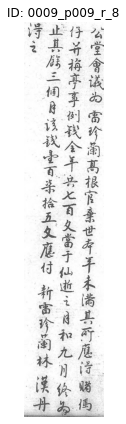

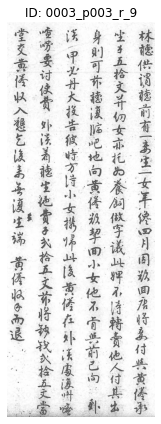

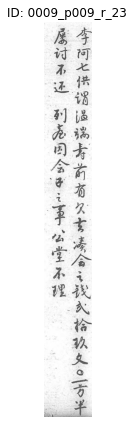

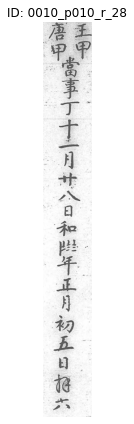

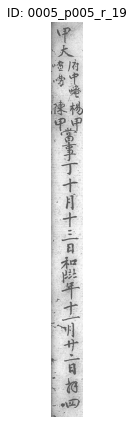

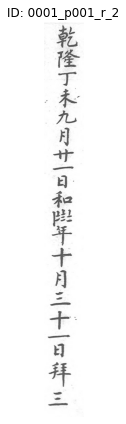

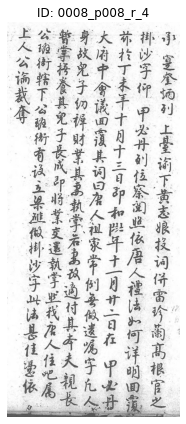

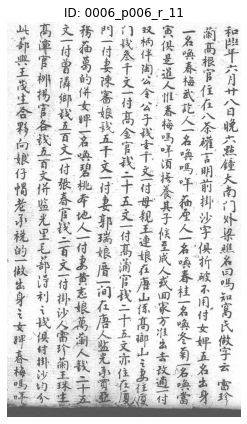

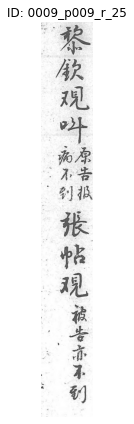

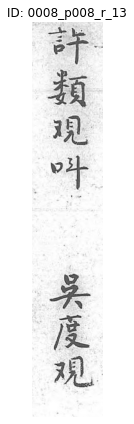

In [21]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import difflib
import pandas as pd
import warnings

# Silence the specific warning about pad_token_id
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`.*")

def highlight_diff(text1, text2):
    """Highlight differences between two strings, returning HTML with blue highlighting"""
    d = difflib.Differ()
    diff = list(d.compare(text1, text2))
    
    text1_chars = []
    text2_chars = []
    
    for i, s in enumerate(diff):
        if s.startswith('  '):  # Common character
            text1_chars.append(f'<span>{s[2:]}</span>')
            text2_chars.append(f'<span>{s[2:]}</span>')
        elif s.startswith('- '):  # In text1 but not text2
            text1_chars.append(f'<span style="background-color:skyblue">{s[2:]}</span>')
        elif s.startswith('+ '):  # In text2 but not text1
            text2_chars.append(f'<span style="background-color:skyblue">{s[2:]}</span>')
    
    return ''.join(text1_chars), ''.join(text2_chars)

def display_results(df, num_examples=5):
    """Display images with ground truth and prediction text"""
    for i in range(min(num_examples, len(df))):
        example = df.iloc[i]
        
        # Get text and highlight differences
        ground_truth = example['ground_truth']
        prediction = example['prediction']
        identifier = example['identifier']
        
        gt_html, pred_html = highlight_diff(ground_truth, prediction)
        
        # Try to retrieve the image if available in the DataFrame
        img = None
        if 'image' in example:
            img = example['image']
        
        # Display image if available
        if img is not None:
            plt.figure(figsize=(10, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"ID: {identifier}")
            plt.tight_layout()
            plt.show()
        
        # Display the text with highlighted differences using HTML
        display(HTML(f"""
        <div style="font-size: 16px; font-family: Arial, sans-serif;">
            <p><b>ID:</b> {identifier}</p>
            <p><b>Ground Truth:</b> {gt_html}</p>
            <p><b>Prediction:</b> {pred_html}</p>
            <hr>
        </div>
        """))

# Process the dataset and generate results
results = []
counter = 0

for example in dataset:
    text = example['text']  # Ground truth
    image = example['image']   # Image data
    identifier = example['identifier']
    # Process the image
    prediction = process_image(image)
    # Save the result as a dictionary
    results.append({
        'ground_truth': text, 
        'prediction': prediction, 
        'identifier': identifier,
        'image': image  # Include the image in results
    })
    print(f"Processed image number {counter}", end="\r", flush=True)
    counter += 1

# Convert the results into a pandas DataFrame
df = pd.DataFrame(results)

# Display the results with highlighted differences
print(f"\nTotal processed: {counter}")
display_results(df, num_examples=13)  # Adjust number as needed

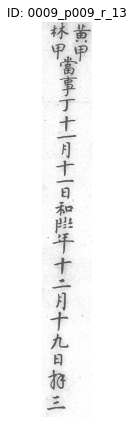

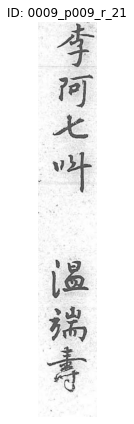

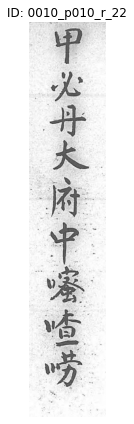

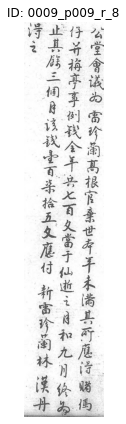

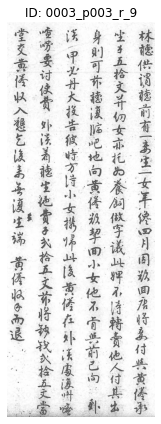

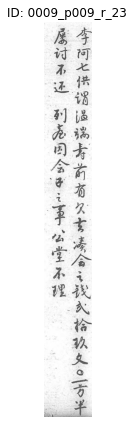

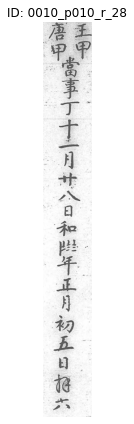

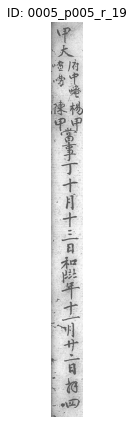

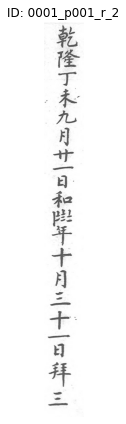

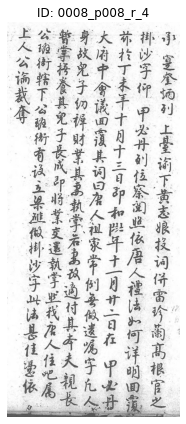

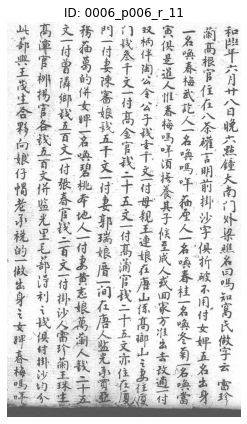

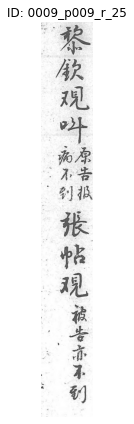

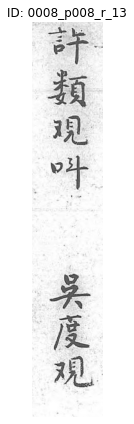

In [22]:
display_results(df, num_examples=13)  # Adjust number as needed